In [5]:
from dataloader_utils import get_conbined_permute_mnist, get_conbined_split_mnist, get_conbined_splitted_and_shuffled_mnist
from autoencoder import Autoencoder
from autoencoder_utils import * 

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from tqdm.notebook import tqdm

In [ ]:
def data_test2(train_loader, autoencoder, auto_index):
    fig = plt.figure(3)

    for i in range(5, 100):
        test_batch = train_loader[i]
        images, labels, current_index = test_batch
        #print(current_index[0])
        if (current_index[0].item()==index[0].item()):
            prediction = auto_a.get_prediction(images)
            unreducted = torch.mean(auto_a.get_unreduced_loss(prediction, images), dim=1).cpu().numpy()
            plt.hist(unreducted, bins=np.arange(0, max(unreducted)+0.1, 1e-2), histtype="step", label = f"Data from task: {current_index[0].item()}")
            break
        else:
            continue

    for i in range(5, 100):
        test_batch = train_loader[i]
        images, labels, current_index = test_batch
        #print(current_index[0])
        if (current_index[0].item()!=index[0].item()):
            prediction = auto_a.get_prediction(images)
            unreducted = torch.mean(auto_a.get_unreduced_loss(prediction, images), dim=1).cpu().numpy()
            plt.hist(unreducted, bins=np.arange(0, max(unreducted)+0.1, 1e-2), histtype="step", label = f"Data from task: {current_index[0].item()}")
            break
        else:
            continue


    prediction = auto_a.get_prediction(train_images)
    unreducted = torch.mean(auto_a.get_unreduced_loss(prediction, train_images), dim=1).cpu().numpy()
    plt.hist(unreducted, bins=np.arange(0, max(unreducted)+0.1, 1e-2), histtype="step", label = f"Training data {index[0].item()}")

    plt.title("Loss vs Frequency")
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend() 

In [8]:
def qqplot(images, task_index, record, num_train_list, auto_list, style='bmh'):
    figsize=((len(auto_list)+1)*10, 5)
    fig = plt.figure(figsize=figsize)
    #mpl.rcParams['font.family'] = 'Ubuntu Mono'
    layout = (1, len(auto_list)+1)
        
    #print(layout)
    y_list = {}
    plot_location_y = 0
    for i in range(len(auto_list)):
        autoencoder = auto_list[i]
        auto_index = record[i]
        num_train = num_train_list[i]/BATCH_SIZE
        
        pred = autoencoder.get_prediction(images)
        y = torch.mean(autoencoder.get_unreduced_loss(pred, images), dim=1).cpu().numpy()        
        y_list[i] = y
        
        if not isinstance(y, pd.Series):
            y = pd.Series(y)
        with plt.style.context(style):    
            #print((plot_location_x, plot_location_y))
            qq_ax = plt.subplot2grid(layout, (0, plot_location_y))
            sm.qqplot(y, line='s', ax=qq_ax)
            qq_ax.set_title('QQ Plot with Gaussian')
            plt.title(f"Task {task_index}, auto {auto_index} trained with {int(num_train)} batches")
        plot_location_y += 1
    
    hist_ax = plt.subplot2grid(layout, (0, plot_location_y))
    for i in range(len(auto_list)):
        y = y_list[i]
        hist_ax.hist(y, bins=np.arange(0, max(y)+0.1, 1e-2), histtype="step", label = f"Loss from autoencoder: {i}")      

    plt.title("Loss vs Frequency")
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend() 
    
    plt.tight_layout()
    plt.show()

In [9]:
def auto_test1(train_loader, expert_outdim, plot_epoch):
    auto_list = {}
    expert_list = {}
    #debug
    record = {}
    #for i, data in enumerate(train_loader):
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, labels, indicies = data
        
        #initial
        if len(auto_list)==0:
            #debug
            print(f"[@ batch {i}] NEW autoencoder at {len(auto_list)} for Task {indicies[0].item()}")
            record[len(auto_list)] = indicies[0].item()

            #initial autoencoder
            new_autoencoder = Autoencoder(input_dims=28*28, code_dims=CODE_DIM)
            for epoch in range(NEW_AUTOENCODER_EPOCH):
                new_autoencoder.optimize_params(images, images)
            auto_list[len(auto_list)] = new_autoencoder

            #ignore expert part
            expert_list[len(expert_list)] = BATCH_SIZE
            
            qqplot(images, indicies[0].item(), record, expert_list, auto_list)
            continue
            
        #find best autoencoder
        best_index = find_best_autoencoders(images, auto_list)
        best_autoencoder = auto_list[best_index]


        #calculate outliers
        outliers = find_num_of_outliers(images, best_autoencoder)
        #print(f"[@ batch {i}] outliers for best autoencoders {best_index}: {outliers}")

        if outliers > OUTLIER_THRESHOLD:
            #debug
            print(f"[@ batch {i}] outliers for best autoencoders at index: {best_index} : {outliers}")
            print(f"[@ batch {i}] NEW autoencoder at {len(auto_list)} for Task: {indicies[0].item()}")
            if indicies[0].item() in record.keys():
                print(f"[@ batch {i}] DUPLICATE autoencoder for Task: {indicies[0].item()}")
            record[len(auto_list)] = indicies[0].item()
            
            #add new autoencoder
            best_autoencoder = Autoencoder(input_dims=28*28, code_dims=CODE_DIM)
            for epoch in range(NEW_AUTOENCODER_EPOCH):
                best_autoencoder.optimize_params(images, images)
            auto_list[len(auto_list)] = best_autoencoder

            #ignore expert part
            expert_list[len(expert_list)] = BATCH_SIZE
            
        else:
            #debug
            #print(f"training autoencoder at {best_index} with index: {indicies[0].item()}")
            if not indicies[0].item() in record.values():
                print(f"[@ batch {i}] outliers for best autoencoders at index: {best_index} : {outliers}")
                print(f"[@ batch {i}] MISSING autoencoder with Task {indicies[0].item()}")
                
            #train best autoencoder
            for epoch in range(TRAIN_AUTOENCODER_EPOCH):
                best_autoencoder.optimize_params(images, images)

            #ignore expert part
            expert_list[best_index] += BATCH_SIZE

        if i % plot_epoch == 0:
            
            #print(auto_list)
            #best_pred = best_autoencoder.get_prediction(images)
            #sample_loss = torch.mean(best_autoencoder.get_unreduced_loss(best_pred, images), dim=1)
            #sort_loss, _ = torch.sort(sample_loss, descending=True)
            #plt.plot(list(range(sample_loss.shape[0])), sort_loss.cpu().detach().numpy())
            qqplot(images, indicies[0].item(), record, expert_list, auto_list)
            #print(record[indicies[0].item()])

    print("Complete!")
    #debug
    print(expert_list)

    return auto_list, expert_list

In [32]:
BATCH_SIZE = 300

OUTLIER_THRESHOLD = 0.2*BATCH_SIZE
NEW_AUTOENCODER_EPOCH = 100
TRAIN_AUTOENCODER_EPOCH = 10
CODE_DIM = 350

NUM_TASK = 2
RANDOM_SEED = np.random.randint(100)
#RANDOM_SEED = 42

In [33]:
train_loader, test_loader = get_conbined_permute_mnist(NUM_TASK, BATCH_SIZE, RANDOM_SEED)

  0%|          | 0/400 [00:00<?, ?it/s]

[@ batch 0] NEW autoencoder at 0 for Task 1


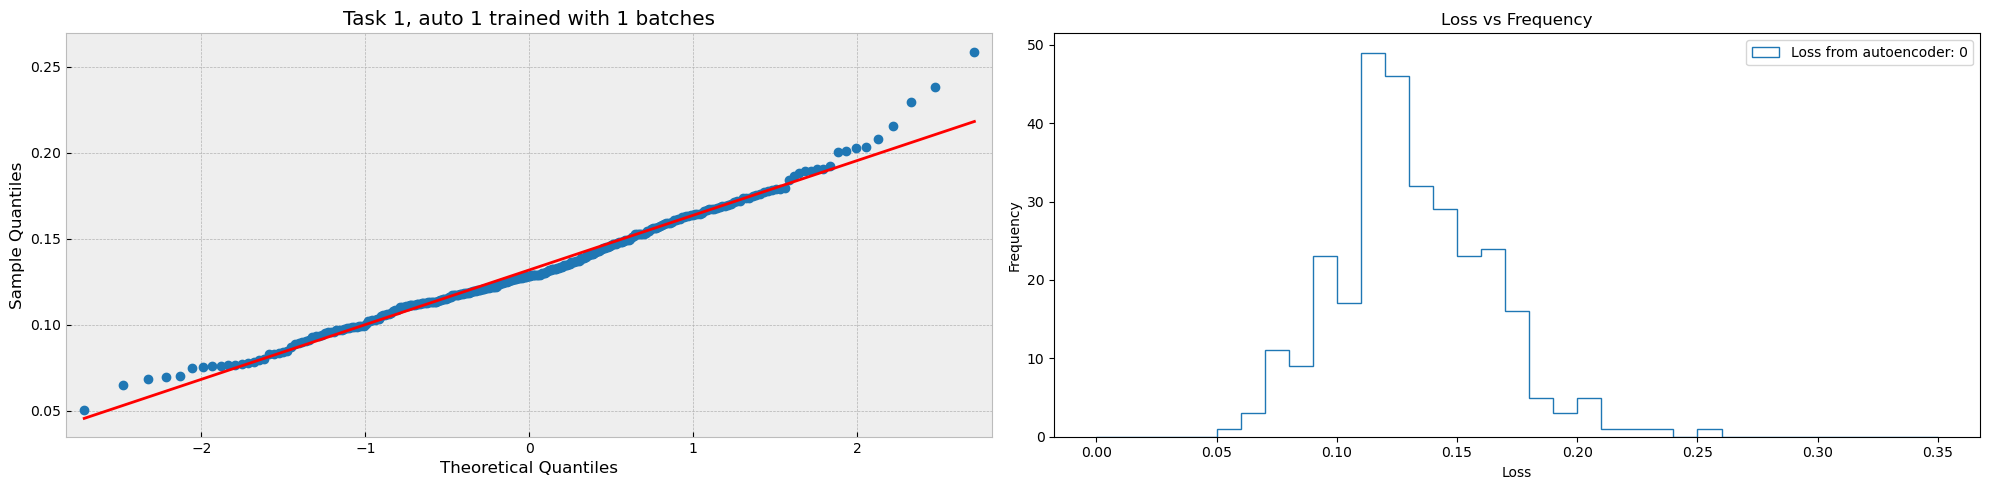

[@ batch 1] outliers for best autoencoders at index: 0 : 300
[@ batch 1] NEW autoencoder at 1 for Task: 0
[@ batch 1] DUPLICATE autoencoder for Task: 0


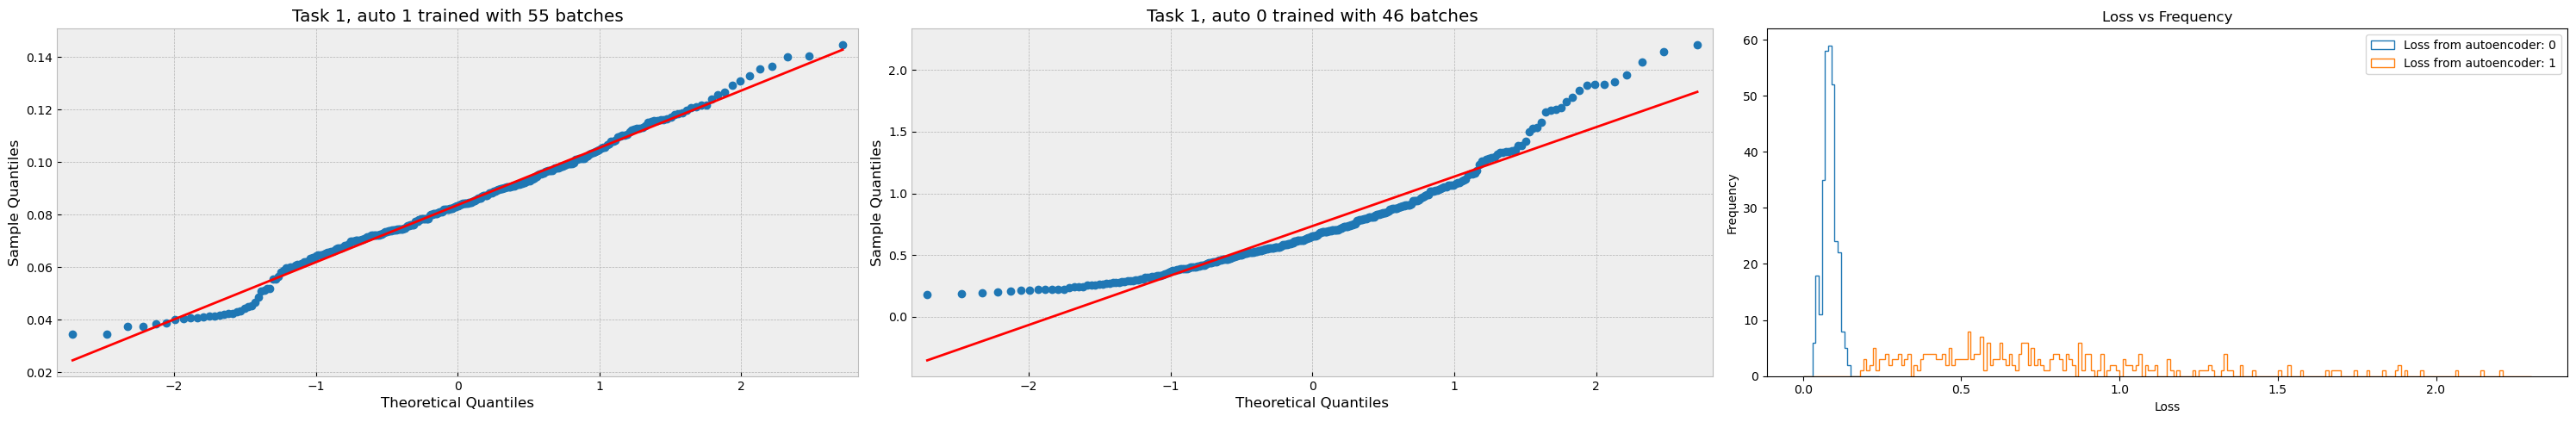

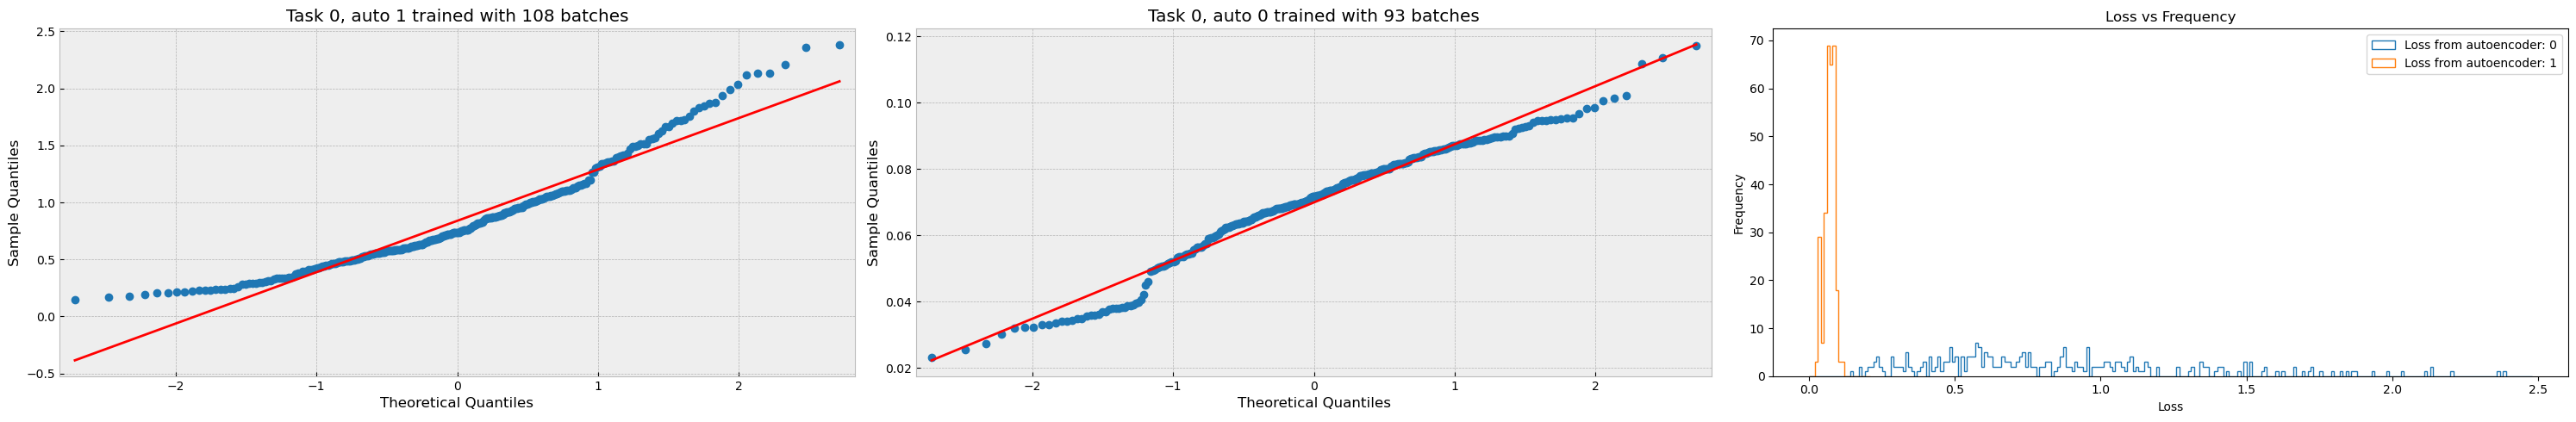

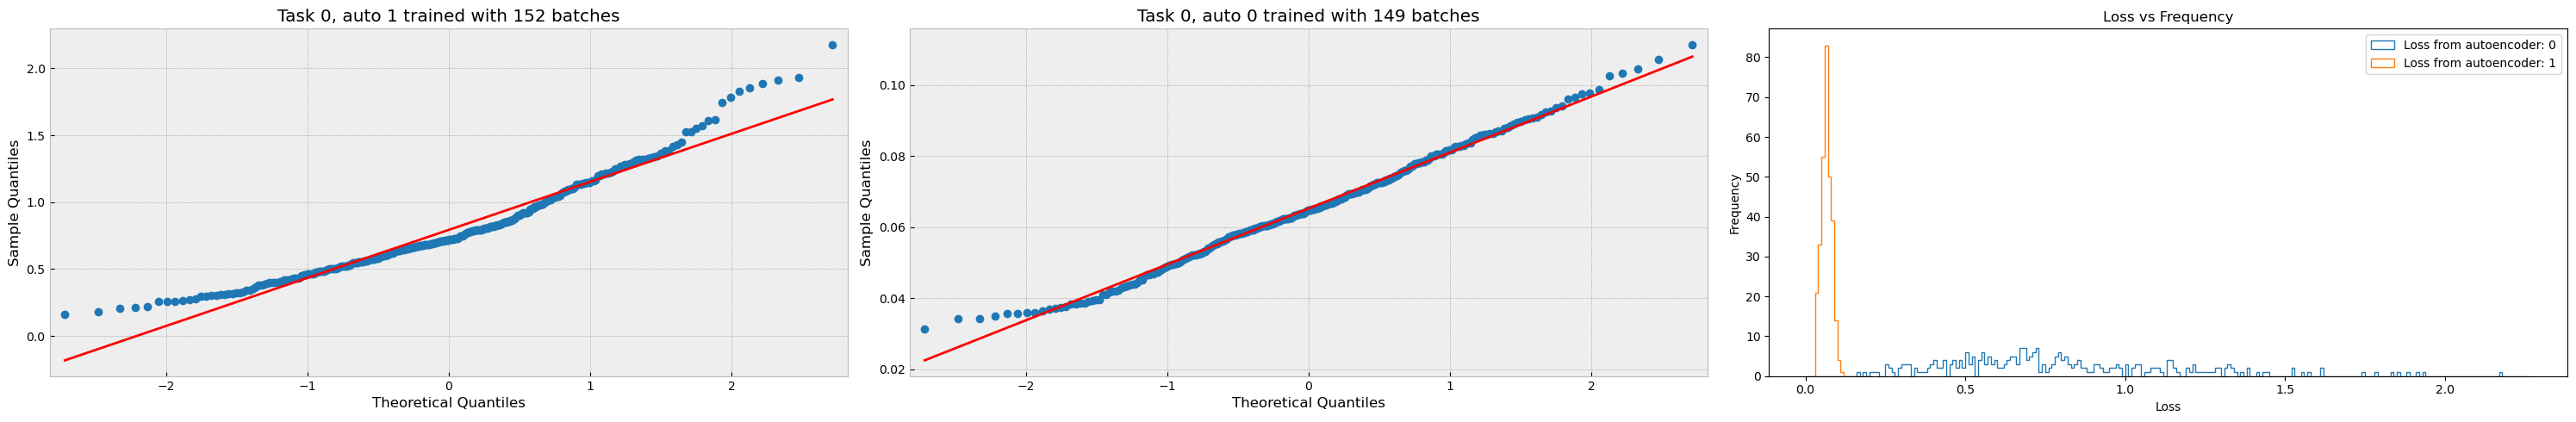

Complete!
{0: 60000, 1: 60000}


({0: <autoencoder.Autoencoder at 0x281931b74c0>,
  1: <autoencoder.Autoencoder at 0x281931b4c40>},
 {0: 60000, 1: 60000})

In [34]:
auto_test1(train_loader, 10, 100)

tensor(1)


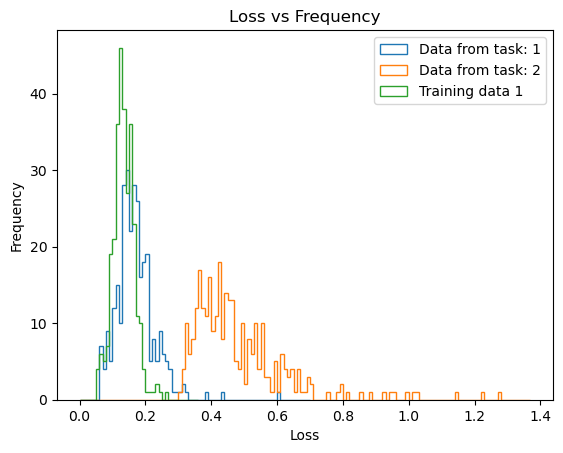

In [14]:
training_batch = train_loader[0]
train_images, labels, index = training_batch
print(index[0])
auto_a = Autoencoder(input_dims=28*28, code_dims=CODE_DIM)
for epoch in range(NEW_AUTOENCODER_EPOCH):
    auto_a.optimize_params(train_images, train_images)

data_test2(train_loader, auto_a, index)

In [443]:
BATCH_SIZE = 300

OUTLIER_THRESHOLD = 0.2*BATCH_SIZE
NEW_AUTOENCODER_EPOCH = 100
TRAIN_AUTOENCODER_EPOCH = 10
CODE_DIM = 500

NUM_TASK = 3
RANDOM_SEED = np.random.randint(100)
#RANDOM_SEED = 42

In [445]:
train_loader, test_loader, shuffle_idx = get_conbined_splitted_and_shuffled_mnist(NUM_TASK, BATCH_SIZE, RANDOM_SEED)

split classes: [[5, 8], [6, 0], [2, 4]]


  0%|          | 0/600 [00:00<?, ?it/s]

[@ batch 0] NEW autoencoder at 0 for Task 1


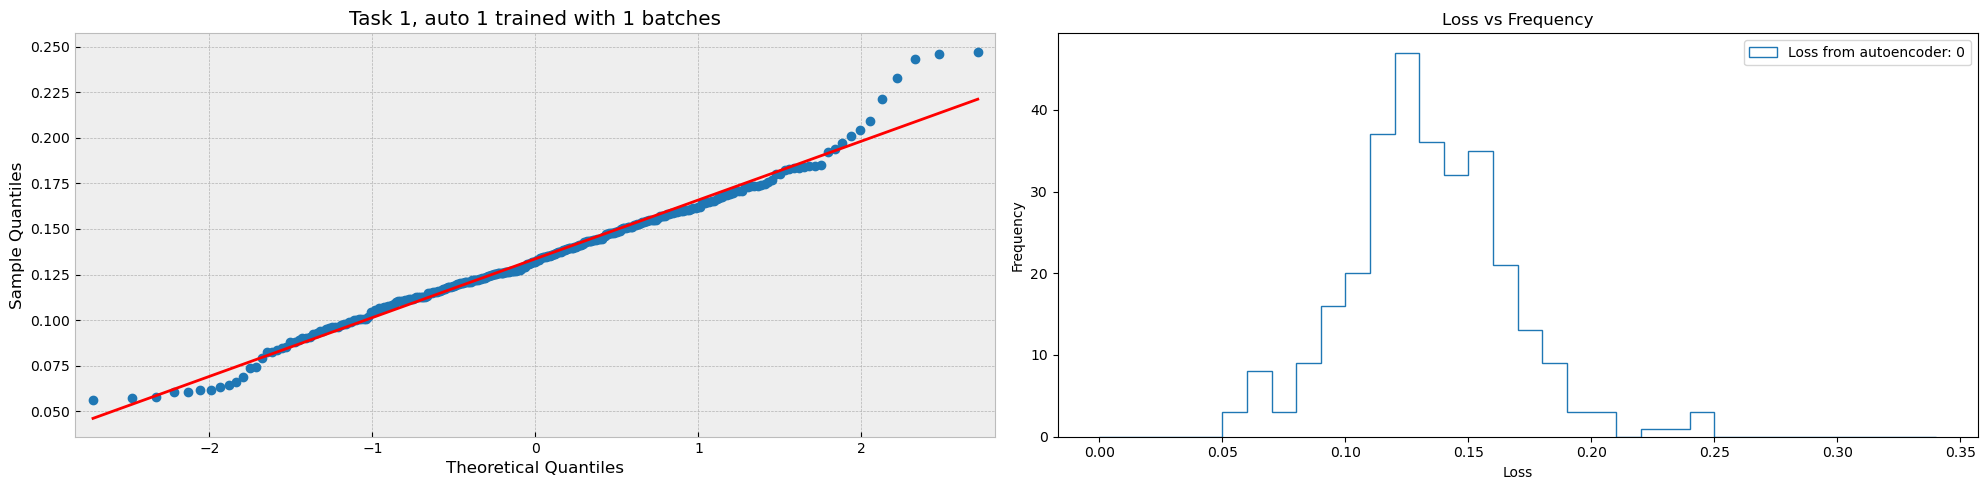

[@ batch 1] outliers for best autoencoders at index: 0 : 300
[@ batch 1] NEW autoencoder at 1 for Task: 2
[@ batch 2] outliers for best autoencoders at index: 0 : 300
[@ batch 2] NEW autoencoder at 2 for Task: 0
[@ batch 2] DUPLICATE autoencoder for Task: 0


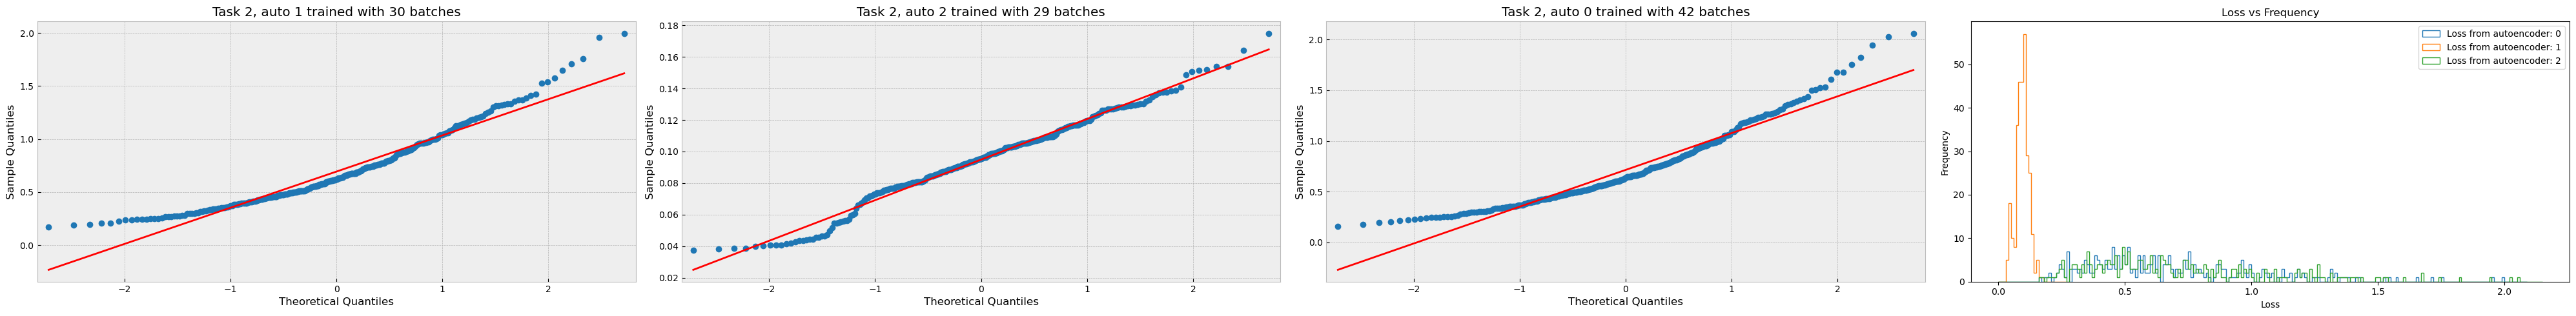

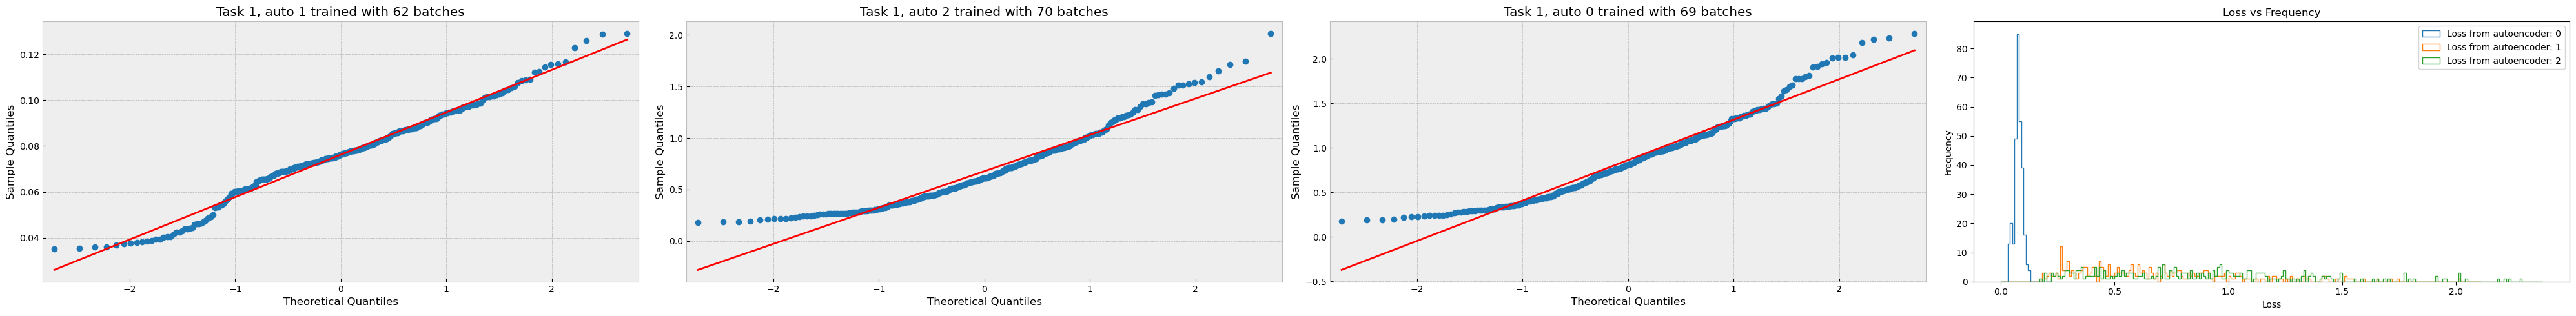

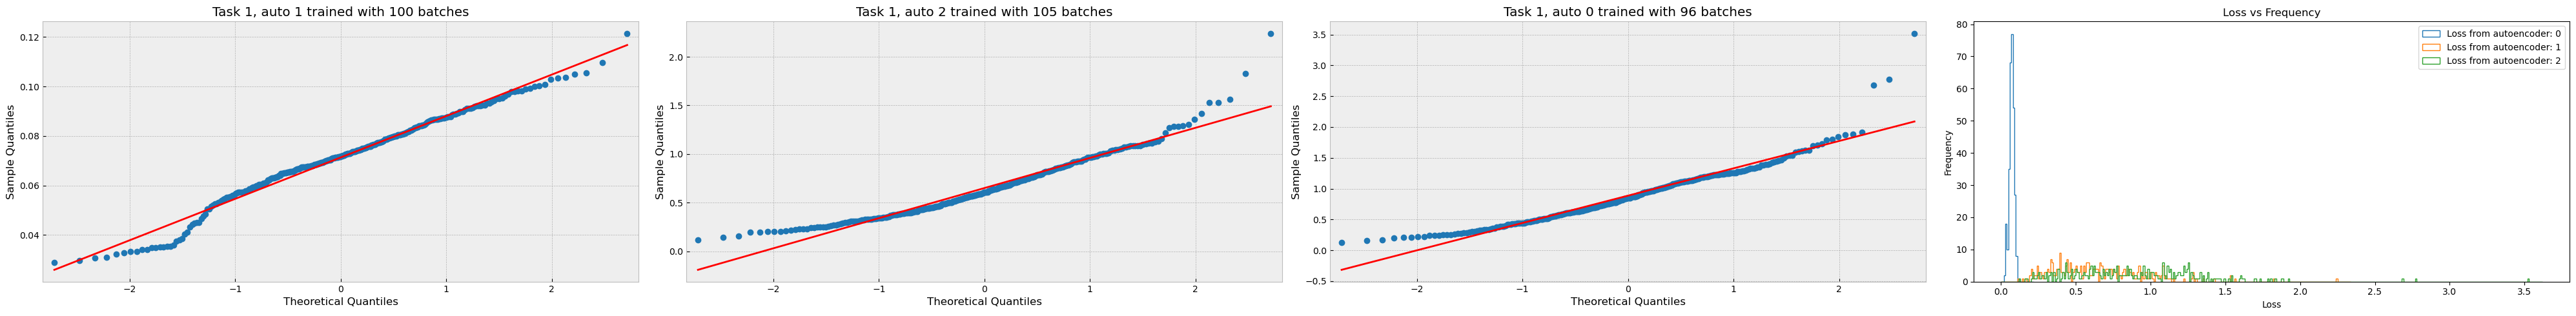

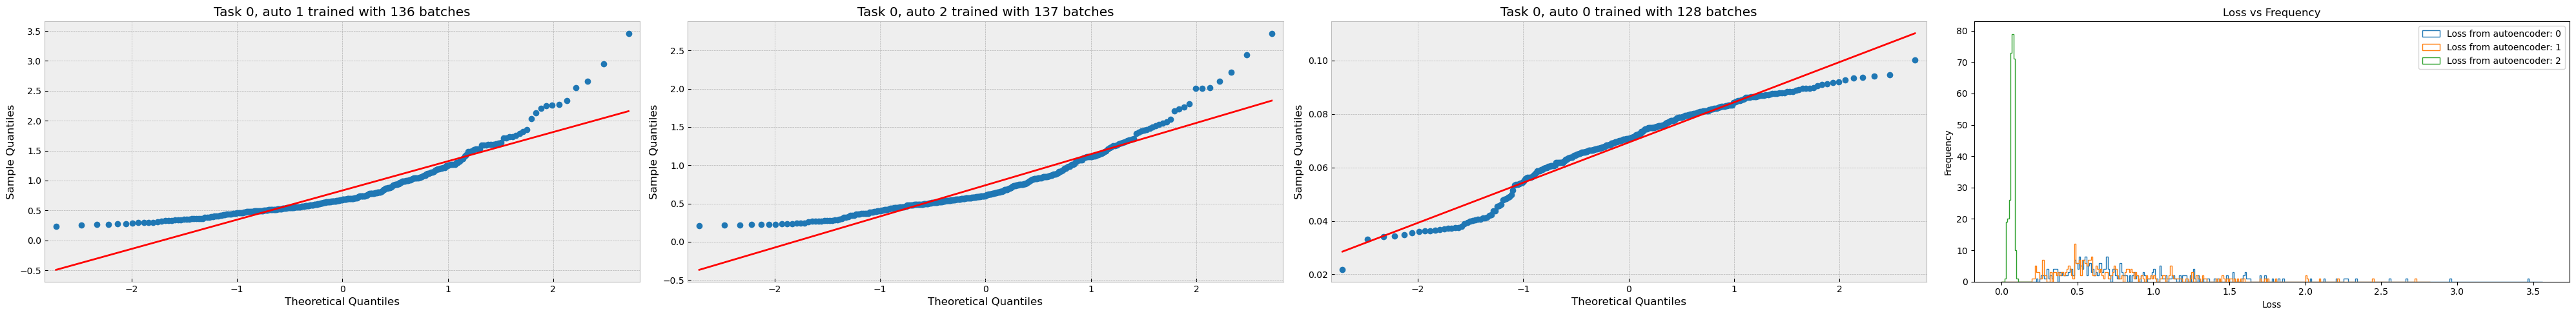

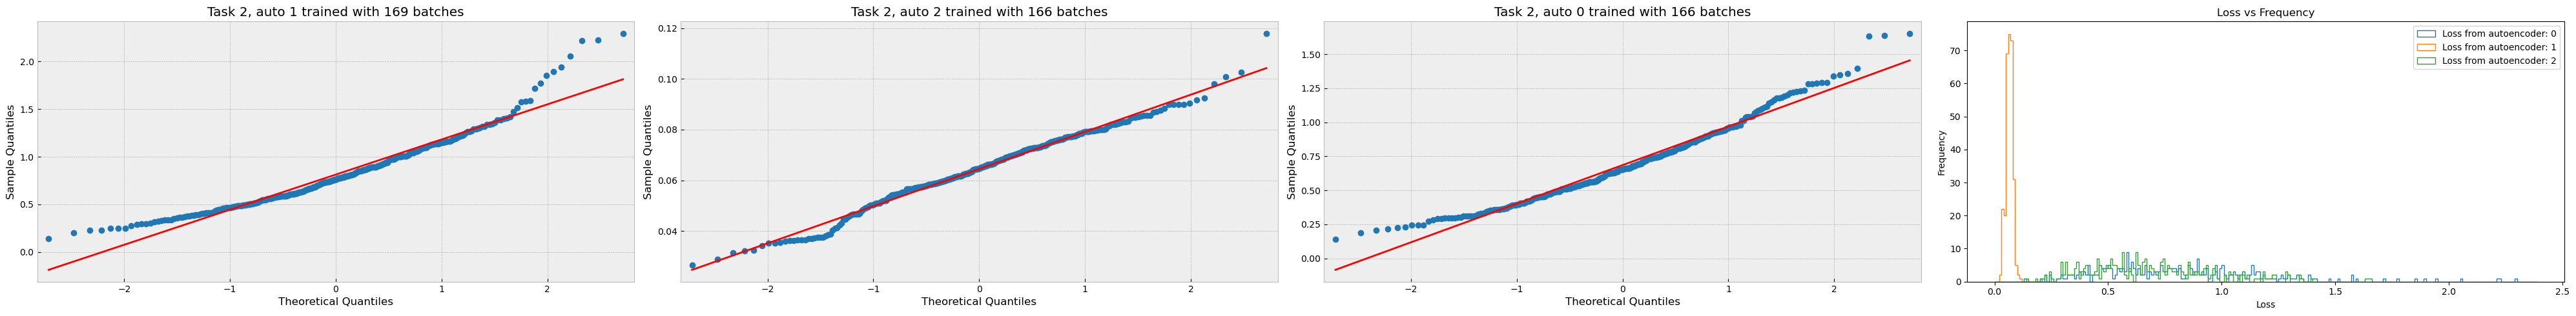

Complete!
{0: 60000, 1: 60000, 2: 60000}


({0: <autoencoder.Autoencoder at 0x281c0beb1c0>,
  1: <autoencoder.Autoencoder at 0x281ff4e9330>,
  2: <autoencoder.Autoencoder at 0x281c0dc88b0>},
 {0: 60000, 1: 60000, 2: 60000})

In [21]:
auto_test1(train_loader, 10, 100)

tensor(1)


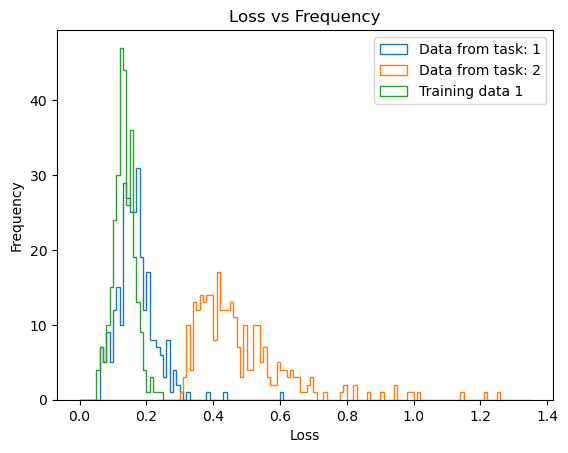

In [23]:
training_batch = train_loader[0]
train_images, labels, index = training_batch
print(index[0])
auto_a = Autoencoder(input_dims=28*28, code_dims=CODE_DIM)
for epoch in range(NEW_AUTOENCODER_EPOCH):
    auto_a.optimize_params(train_images, train_images)

data_test2(train_loader, auto_a, index)